In [1]:
import os

import contextily as ctx
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from matplotlib import cm
import networkx as nx
from joblib import Parallel, delayed

In [2]:
enriched_points = dd.read_csv(
    "./anglova_metrics_enriched/points_enriched_metrics.csv",
).compute()
enriched_points["t"] = pd.to_datetime(enriched_points["t"])
enriched_trajectories_df = pd.read_csv(
    "./anglova_metrics_enriched/trajectories_enriched_metrics.csv",
)
pair_wise_distances = enriched_points = dd.read_csv(
    "./pairwise_distances.csv",
).compute()


In [3]:
output_path = "./assets/Connectivity/"
pallete = "Set1"
pallete2 = "Set2"

In [4]:
def save_plot(filename):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(
        f"{output_path}/{filename}.png",
        bbox_inches="tight",
    )
    plt.savefig(
        f"{output_path}/{filename}.pdf",
        bbox_inches="tight",
    )

In [5]:
cud_okabe_ito_colors = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # reddish orange
    "#CC79A7",  # purple
    "#000000",  # black
]

In [6]:
# Combine data for both companies and plot in one figure

# Convert the 't' column to datetime if not already done
pair_wise_distances['t'] = pd.to_datetime(pair_wise_distances['t'])

# Set the time interval (e.g., 10 minutes)
time_interval = '10T'

# Create a dictionary to store max distances for each company
max_distances_by_company = {}
min_distances_by_company = {}
avg_distances_by_company = {}
plt.rcParams.update({'font.size': 24})
# Process data for each company
for company in enriched_trajectories_df["Company"].unique():
    company_ids = enriched_trajectories_df[enriched_trajectories_df["Company"] == company]["trajectory_id"]
    filtered_rows = pair_wise_distances[
        pair_wise_distances["id1"].isin(company_ids) | pair_wise_distances["id2"].isin(company_ids)
    ]
    resampled_data = filtered_rows.set_index('t').resample(time_interval)['distance']
    max_distances_by_company[company] = resampled_data.max()
    min_distances_by_company[company] = resampled_data.min()
    avg_distances_by_company[company] = resampled_data.mean()

C:\Users\edgar\AppData\Local\Temp\ipykernel_16660\2953901240.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = filtered_rows.set_index('t').resample(time_interval)['distance']


In [7]:
def get_company_color(company):
    if company == 6:
        return sns.color_palette("Set2")[company - 1 % len(sns.color_palette("Set2"))]
    return sns.color_palette("Set1")[company - 1 % len(sns.color_palette("Set1"))]

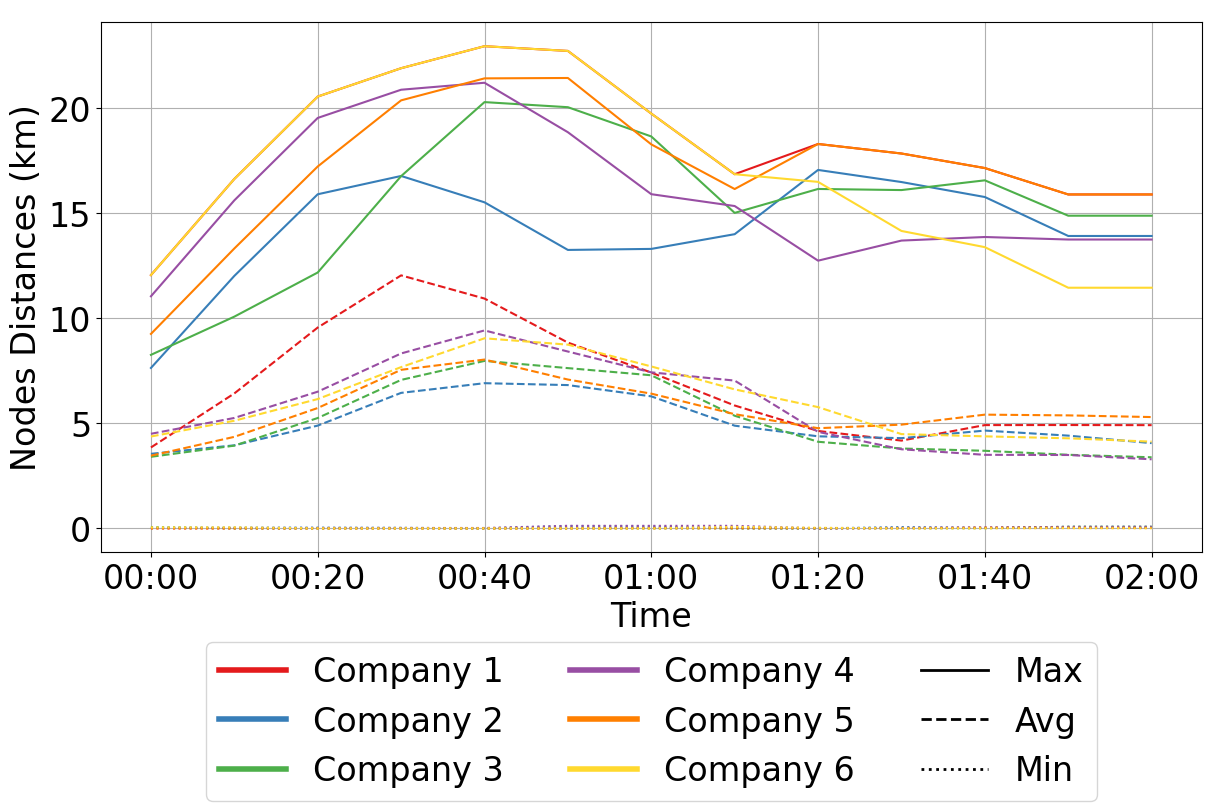

In [121]:
# Plot the results
plt.figure(figsize=(12, 8), constrained_layout=True)
plt.rcParams.update({"font.size": 24})
for company in enriched_trajectories_df["Company"].unique():

    max_distances = max_distances_by_company[company]
    min_distances = min_distances_by_company[company]
    avg_distances = avg_distances_by_company[company]

    # max_distances.index = max_distances.index.strftime("%H:%M")
    # min_distances.index = min_distances.index.strftime("%H:%M")
    # avg_distances.index = avg_distances.index.strftime("%H:%M")

    plt.plot(
        max_distances.index,
        max_distances,
        linestyle="-",
        color=get_company_color(company),
    )
    plt.plot(
        min_distances.index,
        min_distances,
        linestyle=":",
        color=get_company_color(company),
    )
    plt.plot(
        avg_distances.index,
        avg_distances,
        linestyle="--",
        color=get_company_color(company),
    )

# plt.title("Maximum Distances Over Time (10-minute intervals)")
plt.xlabel("Time")
# Set custom x-axis tick labels
ax = plt.gca()  # Get the current axis
tick_locations = avg_distances.index[::2]  # Use the index of avg_distances as tick locations
ax.set_xticks(tick_locations)  # Set the tick locations
ax.set_xticklabels(
    [t.strftime("%H:%M") for t in tick_locations], rotation=0, ha="center"
)  # Format the tick labels to show only hours and minutes
plt.xticks()
plt.ylabel("Nodes Distances (km)")
# Create a custom legend for companies
custom_legend = [
    plt.Line2D(
        [0],
        [0],
        color=get_company_color(company),
        lw=4,
        label=f"Company {company}",
    )
    for i, company in enumerate(enriched_trajectories_df["Company"].unique())
]
plt.legend(
    handles=custom_legend + [
        plt.Line2D([0], [0], color='black', linestyle='-', lw=2, label='Max'),
        plt.Line2D([0], [0], color='black', linestyle='--', lw=2, label='Avg'),
        plt.Line2D([0], [0], color='black', linestyle=':', lw=2, label='Min'),
    ],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.5),
    ncol=3
)

plt.grid()
plt.title(" ", y=0.95)
save_plot("Company_Min_Max_Mean_Distances_Over_Time")
plt.show()

In [9]:
def calculate_metrics(pair_wise_distances, radius=1.0):
    # Calculate average inter-vehicle distance
    avg_distance = pair_wise_distances['distance'].mean()

    # Calculate standard deviation of inter-vehicle distances
    std_distance = pair_wise_distances['distance'].std()

    # Calculate time spent within a given radius
    within_radius = pair_wise_distances[pair_wise_distances['distance'] <= radius]
    time_within_radius = within_radius.groupby('t').size().sum()

    return avg_distance, std_distance, time_within_radius

# Example usage
radius = 1.0  # Define the radius
avg_distance, std_distance, time_within_radius = calculate_metrics(pair_wise_distances, radius)

print(f"Average Distance: {avg_distance}")
print(f"Standard Deviation of Distance: {std_distance}")
print(f"Time Spent Within {radius} km Radius: {time_within_radius / 3600:.2f} hours")

Average Distance: 5.520389329805276
Standard Deviation of Distance: 4.2118727721531295
Time Spent Within 1.0 km Radius: 2560.89 hours


### Compute Graph-Based Cohesion

In [8]:
proximity_graphs_by_time = {}

# Ensure the 't' column is in datetime format
pair_wise_distances['t'] = pd.to_datetime(pair_wise_distances['t'])

# Convert the dataframe to a Dask dataframe for memory-efficient processing
dask_pairwise_distances = dd.from_pandas(pair_wise_distances, npartitions=10)

# Group the data by the time window
grouped_data = dask_pairwise_distances.set_index('t').map_partitions(
    lambda df: df.groupby(pd.Grouper(freq='10T'))
)

# Process each time window
def process_time_window(time, group):
    G = nx.Graph()
    for _, row in group.iterrows():
        if row['distance'] <= 1.0:  # Use the defined distance_threshold value
            G.add_edge(row['id1'], row['id2'], weight=row['distance'])
    return time, G

results = []
for partition in grouped_data.to_delayed():
    partition = partition.compute()  # Convert the Dask dataframe partition to a Pandas dataframe
    for time, group in partition:
        results.append(process_time_window(time, group))

proximity_graphs_by_time = {time: G for time, G in results}


C:\Users\edgar\AppData\Local\Temp\ipykernel_4736\622478422.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  lambda df: df.groupby(pd.Grouper(freq='10T'))
C:\Users\edgar\AppData\Local\Temp\ipykernel_4736\622478422.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  lambda df: df.groupby(pd.Grouper(freq='10T'))


In [9]:
import pickle

# Caminho do arquivo para salvar o dicionário
file_path = "./proximity_graphs_by_time.pkl"

# Salvar o dicionário em um arquivo
with open(file_path, "wb") as file:
    pickle.dump(proximity_graphs_by_time, file)

print(f"proximity_graphs_by_time salvo em {file_path}")

proximity_graphs_by_time salvo em ./proximity_graphs_by_time.pkl


### Load Preprocessed Graph

In [14]:
import pickle

# Path to the file where the dictionary was saved
file_path = "./proximity_graphs_by_time.pkl"

# Load the dictionary from the file
with open(file_path, "rb") as file:
    proximity_graphs_by_time = pickle.load(file)

print("proximity_graphs_by_time loaded successfully.")

proximity_graphs_by_time loaded successfully.


In [15]:
subgraphs_by_company = {}

for company in enriched_trajectories_df["Company"].unique():
    # Obter os IDs dos trajetos da companhia
    company_ids = set(enriched_trajectories_df[enriched_trajectories_df["Company"] == company]["trajectory_id"])
    
    # Filtrar os subgrafos para a companhia
    company_subgraphs = {
        time: graph.subgraph([node for node in graph.nodes if node in company_ids]).copy()
        for time, graph in proximity_graphs_by_time.items()
    }
    
    subgraphs_by_company[company] = company_subgraphs

# Exemplo de como acessar os subgrafos de uma companhia específica
# subgraphs_by_company[1] contém os subgrafos da companhia 1


In [16]:
# Dicionário para armazenar as métricas de conectividade
connectivity_analysis = {}

# Iterar sobre cada companhia
for company, subgraphs in subgraphs_by_company.items():
    for time, graph in subgraphs.items():
        # Calcular as métricas
        num_edges = graph.number_of_edges()  # Número de conexões
        num_nodes = graph.number_of_nodes()  # Número de nós
        num_groups = nx.number_connected_components(graph)  # Número de grupos (componentes conectados)

        # Armazenar as métricas no dicionário
        connectivity_analysis[(company, time)] = {
            "num_edges": num_edges,
            "num_nodes": num_nodes,
            "connected_components": num_groups,
        }

# Exemplo de como acessar as métricas para uma companhia específica
# connectivity_analysis[(company, time)] contém as métricas para a companhia e o timestamp especificados

In [22]:
def get_company_color(company):
    if company == 6:
        return sns.color_palette("Set2")[company - 1 % len(sns.color_palette("Set2"))]
    return sns.color_palette("Set1")[company - 1 % len(sns.color_palette("Set1"))]

In [ ]:
dimension = (12, 8)
bbox_to_anchor = (0.5, -0.35)

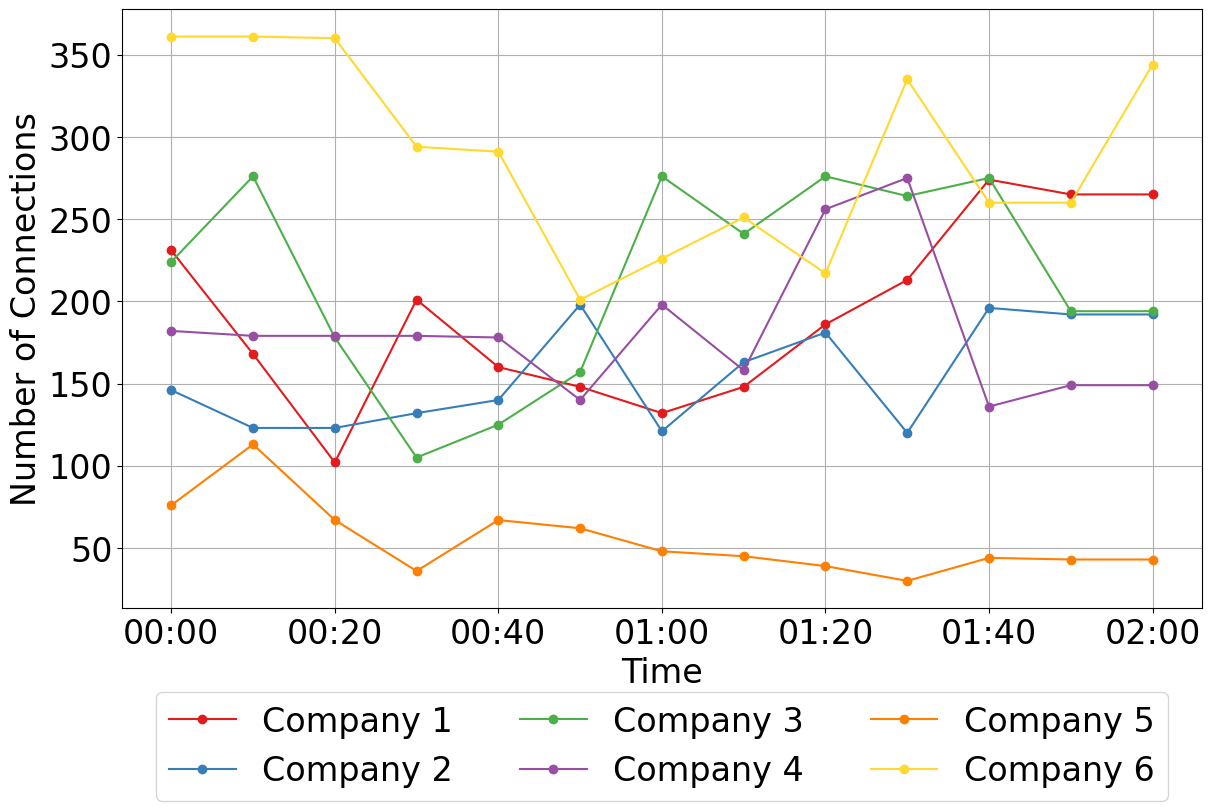

In [111]:
plt.figure(figsize=dimension, constrained_layout=True)
plt.rcParams.update({"font.size": 24})
# Iterate through each company
for company in enriched_trajectories_df["Company"].unique():
    # Filter connectivity analysis for the current company
    company_data = {
        time: metrics
        for (comp, time), metrics in connectivity_analysis.items()
        if comp == company
    }

    # Convert the filtered data to a DataFrame
    company_df = pd.DataFrame.from_dict(company_data, orient="index")
    # company_df.index = company_df.index.strftime(
    #     "%H:%M"
    # )  # Format index to show only hours and minutes
    company_df.index = pd.to_datetime(
        company_df.index
    )  # Ensure the index is datetime

    # Plot the number of edges over time for the current company
    plt.plot(
        company_df.index,
        company_df["num_edges"],
        marker="o",
        label=f"Company {company}",
        color=get_company_color(company),
    )
tick_locations = (
    company_df.index
)  # Use the index of the DataFrame as tick locations

# Set custom x-axis tick labels
ax = plt.gca()  # Get the current axis
tick_locations = company_df.index[::2]# Use the index of avg_distances as tick locations
ax.set_xticks(tick_locations)  # Set the tick locations
ax.set_xticklabels(
    [t.strftime("%H:%M") for t in tick_locations], rotation=0, ha="center"
)  # Format the tick labels to show only hours and minutes
plt.xlabel("Time")
plt.ylabel("Number of Connections")
plt.xticks()
plt.grid()
plt.legend(loc="lower center", bbox_to_anchor=bbox_to_anchor, ncol=3)
save_plot("Number_of_Edges_Over_Time")
plt.show()


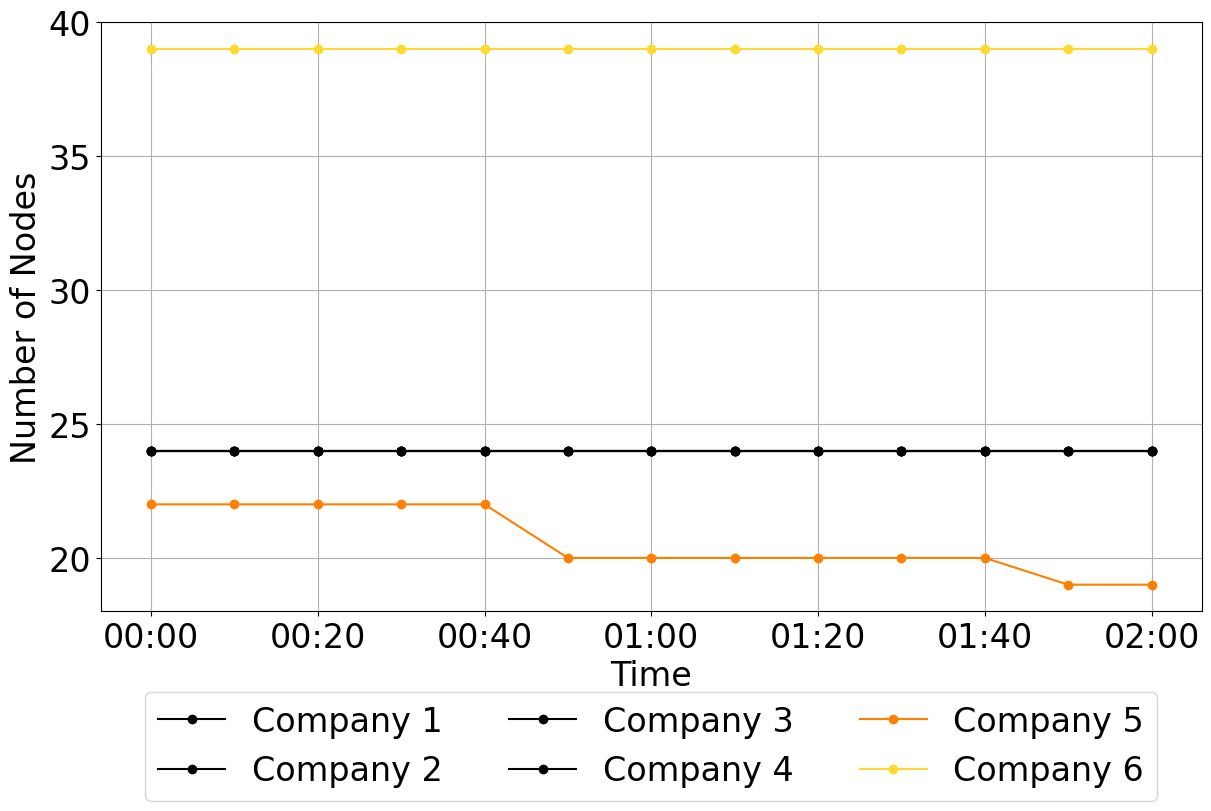

In [112]:
plt.figure(figsize=dimension, constrained_layout=True)
plt.rcParams.update({"font.size": 24})
# Iterate through each company
for company in enriched_trajectories_df["Company"].unique():
    # Filter connectivity analysis for the current company
    company_data = {
        time: metrics
        for (comp, time), metrics in connectivity_analysis.items()
        if comp == company
    }

    # Convert the filtered data to a DataFrame
    company_df = pd.DataFrame.from_dict(company_data, orient="index")
    # company_df.index = company_df.index.strftime(
    #     "%H:%M"
    # )  # Format index to show only hours and minutes
    company_df.index = pd.to_datetime(
        company_df.index
    )  # Ensure the index is datetime

    # Plot the number of edges over time for the current company
    color = get_company_color(company) if company > 4 else "#000000"
    plt.plot(
        company_df.index,
        company_df["num_nodes"],
        marker="o",
        label=f"Company {company}",
        color=color,
    )
tick_locations = (
    company_df.index
)  # Use the index of the DataFrame as tick locations

# Set custom x-axis tick labels
ax = plt.gca()  # Get the current axis
tick_locations = company_df.index[::2]# Use the index of avg_distances as tick locations
ax.set_xticks(tick_locations)  # Set the tick locations
ax.set_xticklabels(
    [t.strftime("%H:%M") for t in tick_locations], rotation=0, ha="center"
)  # Format the tick labels to show only hours and minutes
plt.xlabel("Time")
plt.ylabel("Number of Nodes")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.xticks()
plt.grid()
plt.legend(loc="lower center", bbox_to_anchor=bbox_to_anchor, ncol=3)
save_plot("Number_of_Nodes_Over_Time")
plt.show()


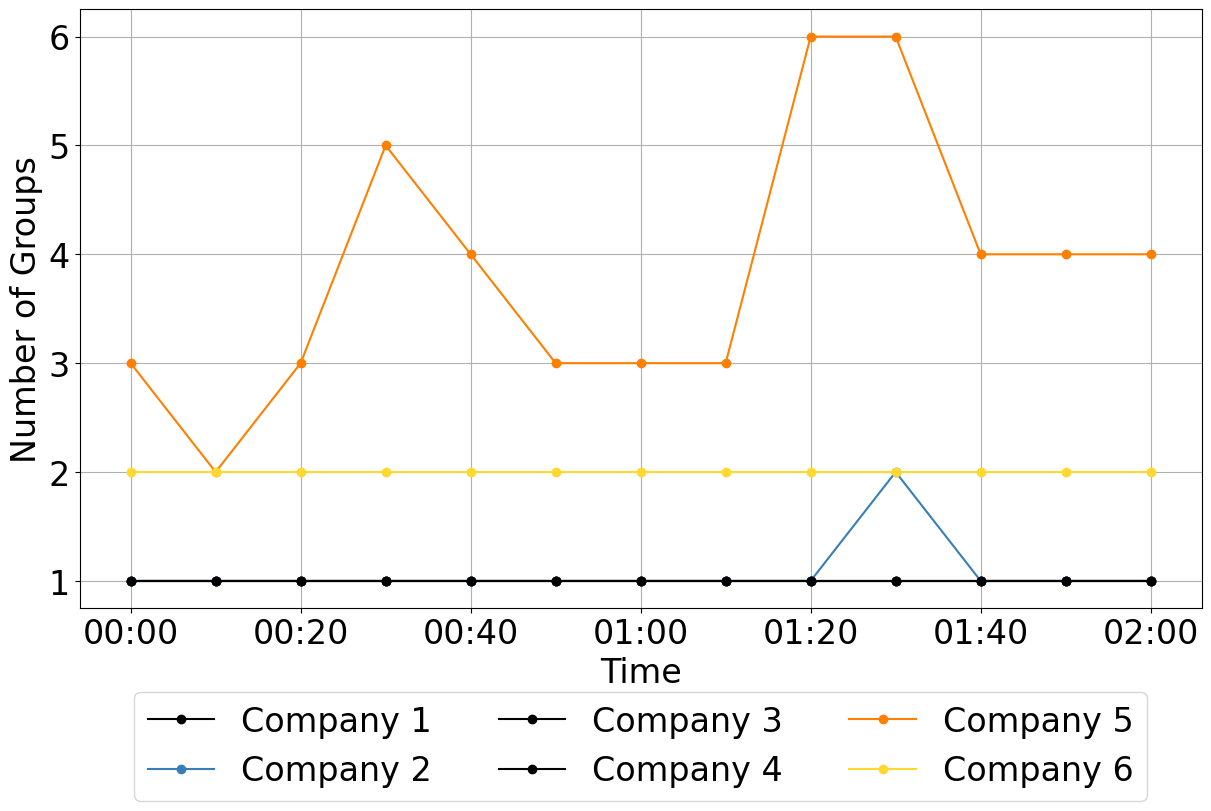

In [113]:
plt.figure(figsize=dimension, constrained_layout=True)
plt.rcParams.update({"font.size": 24})
# Iterate through each company
for company in enriched_trajectories_df["Company"].unique():
    # Filter connectivity analysis for the current company
    company_data = {
        time: metrics
        for (comp, time), metrics in connectivity_analysis.items()
        if comp == company
    }

    # Convert the filtered data to a DataFrame
    company_df = pd.DataFrame.from_dict(company_data, orient="index")
    company_df.index = pd.to_datetime(
        company_df.index
    )  # Ensure the index is datetime

    # Determine color based on company
    color = "#000000" if company in [1, 3, 4] else get_company_color(company)

    # Plot the number of connected components over time for the current company
    plt.plot(
        company_df.index,
        company_df["connected_components"],
        marker="o",
        label=f"Company {company}",
        color=color,
    )
tick_locations = (
    company_df.index
)  # Use the index of the DataFrame as tick locations

# Set custom x-axis tick labels
ax = plt.gca()  # Get the current axis
tick_locations = company_df.index[::2]# Use the index of avg_distances as tick locations
ax.set_xticks(tick_locations)  # Set the tick locations
ax.set_xticklabels(
    [t.strftime("%H:%M") for t in tick_locations], rotation=0, ha="center"
)  # Format the tick labels to show only hours and minutes
plt.xlabel("Time")
plt.ylabel("Number of Groups")
plt.xticks()
plt.grid()
plt.legend(loc="lower center", bbox_to_anchor=bbox_to_anchor, ncol=3)
save_plot("Number_of_Groups_Over_Time")
plt.show()
